**Doxygen** para documentar o codigo

# **Datasets:**

Used in this notebook: https://www.physionet.org/content/ltrsvp/1.0.0/

Possibly used later: https://pypi.org/project/thu-rsvp-dataset/

## **Data Files Information:**

* The data presented here are EEG signals from 8 channels following the 10-20 system (PO8, PO7, PO3, PO4, P7, P8, O1 and O2) during a rapid serial visual presentation (RSVP) task.

* For each presentation rate and participant there are two files. The last field (either "a" or "b") just indicates which one was taken first. Participants took a long break between both files.

* Samples are measured in microVolts.

* The annotations specify the onset of each image, and whether it was a target (T=1) or not (T=0). If the image contained a target, the x-coordinate of its centroid (ranging 0-640, measured in pixels) is also given in the annotation.


In [171]:
import mne
import os, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# **Loading the dataset files**

In [172]:
fname = "eeg-signals-from-an-rsvp-task-1.0.0"

exp0 = "10-Hz"
exp1 = "10Hz"

def run_fast_scandir(dir, ext):    
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles

dt_folder = f"C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/{exp0}"
subfolders, datafiles = run_fast_scandir(dt_folder, [".edf"])

subfolders.sort()
datafiles.sort()

In [173]:
datafiles

['C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_02a.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_02b.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_03a.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_03b.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_04a.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_04b.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_06a.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_06b.edf',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-tas

# **Reading data and managing the data files**

In [174]:
def remove_str(str_list,str2remove): 

     # Function that removes string that contains a certain sub-string from list of strings 

    for string in str_list:
        if str2remove not in string:
            str_list.remove(string)
    return str_list

'''
annot_list = list(annot.description) 

annot_list = remove_str(annot_list,'T=') # Remove the non event-related information
annot_list = remove_str(annot_list,'T=') # Have no idea why but this has run twice to do it right wtf...

annot_xpos = [i.split(',')[1] for i in annot_list] # Position of the target in the x axis. -1 is for the non-target stimuli
'''

"\nannot_list = list(annot.description) \n\nannot_list = remove_str(annot_list,'T=') # Remove the non event-related information\nannot_list = remove_str(annot_list,'T=') # Have no idea why but this has run twice to do it right wtf...\n\nannot_xpos = [i.split(',')[1] for i in annot_list] # Position of the target in the x axis. -1 is for the non-target stimuli\n"

## Visual angle: https://en.wikipedia.org/wiki/Visual_angle

In [175]:
th = 1.2 # Degrees

def visual_angle(object_x_px):

    observer_distance_mm = 800
    image_width_px = 640

    #image_width_deg = np.degrees(2 * (np.arctan(image_width_px / (observer_distance_mm * 2)))) # Visual angle formula
    image_width_deg = 11.5 # Information from the paper, probably acounting for the visual angle of the image inside the screen

    visual_angle_per_px = image_width_deg / image_width_px # How many degrees in the visual field represents one pixel in the images

    object_x_deg = (object_x_px - (image_width_px / 2)) * visual_angle_per_px
    
    return object_x_deg

print(visual_angle(260))

-1.078125


## Checking how much the number of trials of each class differs from the data reported in the paper

**Paper:** "Lateral targets were those the centroid of which was positioned at a visual angle of at least ±1.2 degrees on the horizontal axis (with respect to the centre of the screen). Using this criterion, approximately 60% (144 out of 240) of the targets were classed as lateral. Of these, 59 were located on the Left Visual Field (LVF) and 85 on the Right Visual Field (RVF). Targets that were not lateral were classed as central targets."

['RSVP_burstSize=100_block=0_frame rate=6', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=259', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=134', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=450', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=321', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=173', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=128', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=1,x=400', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', 'T=0,x=-1', '

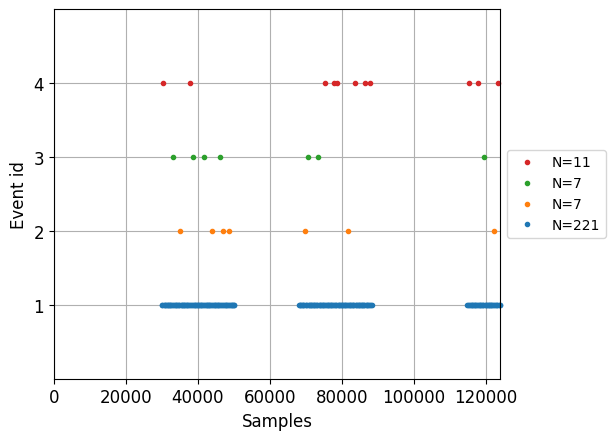

In [176]:
trial = mne.io.read_raw_edf("C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/"+exp0+"\\rsvp_"+exp1+"_02a.edf", preload = True)

ch = trial.ch_names # Channel labels
fs = trial.info["sfreq"] # Sampling frequency

''' Annotations: # Ex -> 'T=0,x=-1' '''
    
annot = trial.annotations 
annot_list = list(annot.description) 

print(annot_list)

annot.description = [re.sub(r"T=0.*", "T0",d) for d in annot.description]

x_pos = []
        
for c,an in enumerate(annot.description):
    if 'x=' in an:
        if visual_angle(int(an.split('x=')[1])) >= 1.2:
            annot.description[c] = 'T1RVF'
            x_pos.append(int(an.split('x=')[1]))
        elif visual_angle(int(an.split('x=')[1])) <= -1.2:
            annot.description[c] = 'T1LVF'
            x_pos.append(int(an.split('x=')[1]))
        elif visual_angle(int(an.split('x=')[1])) > -1.2 and visual_angle(int(an.split('x=')[1])) <1.2: 
            annot.description[c] = 'T1CVF'

print(annot.description)

trial.set_annotations(annot)
events = mne.events_from_annotations(trial, event_id = {'T0': 1, 'T1RVF': 2, 'T1LVF': 3, 'T1CVF': 4})
mne.viz.plot_events(events[0]);

In [177]:
len(x_pos)

14

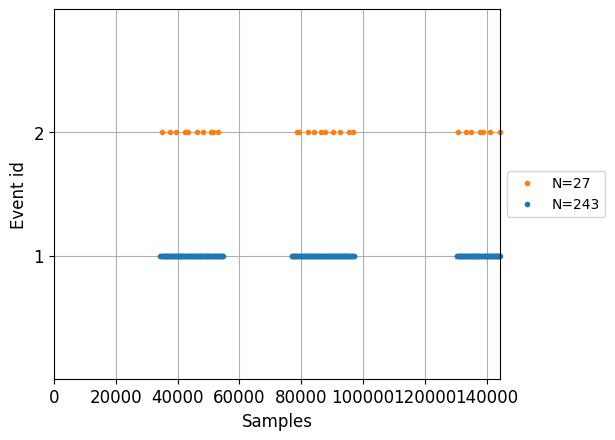

In [178]:
trial = mne.io.read_raw_edf("C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/"+exp0+"\\rsvp_"+exp1+"_03a.edf", preload = True)

ch = trial.ch_names # Channel labels
fs = trial.info["sfreq"] # Sampling frequency

''' Annotations: # Ex -> 'T=0,x=-1' '''
    
annot = trial.annotations 
annot_list = list(annot.description)

annot.description = [re.sub(r"T=0.*", "T0",d) for d in annot.description]
annot.description = [re.sub(r"T=1.*", "T1",d) for d in annot.description]

trial.set_annotations(annot)
events = mne.events_from_annotations(trial, event_id = {'T0': 1, 'T1': 2})
mne.viz.plot_events(events[0]);

**event_id = {'T0': 1, 'T1RVF': 2, 'T1LVF': 3, 'T1CVF': 4}**

rsvp_5Hz_02a.edf: T0 = 359; T1 = 39 | T1RVF = 10; T1LVF = 10; T1CVF = 19

rsvp_5Hz_02b.edf: T0 = 340; T1 = 37 | T1RVF = 11; T1LVF = 11; T1CVF = 15


rsvp_5Hz_03a.edf: T0 = 351; T1 = 38 | T1RVF = 10; T1LVF = 9; T1CVF = 19

rsvp_5Hz_03b.edf: T0 = 337; T1 = 37 | T1RVF = 11; T1LVF = 11; T1CVF = 15

In [179]:
# Is this true: approximately 60% of the targets were classed as lateral for subj 1 and 2 in the dataset?

subj02 = ((10 + 11) + (10 + 11))/(37+39)
print(subj02) 

subj03 = ((10 + 11) + (9 + 11))/(38+37)
print(subj03)

# Answer: Yes

0.5526315789473685
0.5466666666666666


**Number of trials expected for analysis:**

Nº of trials: 24

Nº of Images per trial: 100

Nº of images presented in total: 2400

Nº of trials for **subj02** = 775

Percentage of trials present in this analysis relative to the one conducted in the paper for **subj02** = (775 / 2400) * 100 = 32.3%

Nº of supposed target trials with this percentage = 240 * 0.323 = 77.5

Nº of target trials in this analysis = 76 

---

It checks out that the data is simply not present in the dataset

Nº of trials for **subj03** = 688

Percentage of trials present in this analysis relative to the one conducted in the paper for **subj32** = (668 / 2400) * 100 = 28.6%

Nº of supposed target trials with this percentage = 240 * 0.286 = 68.8

Nº of target trials in this analysis = 75

---

It checks out that the data is simply not present in the dataset

## Actually reading the data

In [180]:
mne.set_log_level('CRITICAL') # Stop MNE library prints about everything 

def load_subject_data(subject, tstart, tstop):

    subj_EEG = []
    
    subj_LVF_x_pos = []
    subj_RVF_x_pos = []

    for eeg_file in subject: # Each eeg_file contains 2 file paths of each participant

        # Function that loads subject data and concatenates all the trials from the files associated with him 

        # MNE does not load the data into memory by default, just links to the file in the directory.
        # preload = True enables the loading of the data into memory for processing
        trial = mne.io.read_raw_edf(eeg_file, preload = True)

        ch = trial.ch_names # Channel labels
        fs = trial.info["sfreq"] # Sampling frequency


        ''' Annotations: # Ex -> 'T=0,x=-1' '''
    
        annot = trial.annotations 
        annot_list = list(annot.description) 
        
        # annot_xpos = [int(i.split('x=')[1]) for i in annot_list if 'x=' in i] # List with image positions

        annot.description = [re.sub(r"T=0.*", "T0",d) for d in annot.description]
        
        for c,an in enumerate(annot.description):
            if 'x=' in an:
                if visual_angle(int(an.split('x=')[1])) >= 1.2:
                    annot.description[c] = 'T1RVF'
                    subj_RVF_x_pos.append(int(an.split('x=')[1]))
                if visual_angle(int(an.split('x=')[1])) <= -1.2:
                    annot.description[c] = 'T1LVF'
                    subj_LVF_x_pos.append(int(an.split('x=')[1]))
                if visual_angle(int(an.split('x=')[1])) > -1.2 and visual_angle(int(an.split('x=')[1])) <1.2:
                    annot.description[c] = 'T1CVF'
                
        trial.set_annotations(annot)
        print(trial)
        
        '''
        print("Data info: \n")
        print(subj_EEG.info)
        '''

        ''' Events: ''' 

        # Returns 3 columns in the first field [0] -> [Sample Index, Trigger value's Channel, Label of the event] with just the bocks of data from the labels T0 and T1
        # Second field -> Event ids

        events = mne.events_from_annotations(trial, event_id = {'T0': 1, 'T1RVF': 2, 'T1LVF': 3, 'T1CVF': 4}) # This already removes the unecessary labels non-event related. Ex: 'RSVP_burstSize=100_block=0_frame rate=12'
        #mne.viz.plot_events(events[0])

        ''' Epoching '''

        event_ids = {"standard/stimulus": 1, "targetRVF/stimulus": 2, "targetLVF/stimulus": 3, "targetCVF/stimulus": 4}
        epochs = mne.Epochs(trial, events[0], event_id = event_ids, # mne.Epochs: https://mne.tools/stable/generated/mne.Epochs.html
                            tmin = tstart, tmax = tstop, 
                            baseline = (-0.2,0.0), 
                            preload = True)
        

        '''
        print("Epochs info: \n")
        print(epochs.info)  
        '''
        
        subj_EEG.append(epochs)

    ''' Epoch concatenation '''

    subject_epochs = mne.concatenate_epochs(subj_EEG, add_offset = True, on_mismatch = 'raise')

    return subject_epochs, subj_RVF_x_pos, subj_LVF_x_pos

In [181]:
all_subj_epochs = []
all_subj_RVF_x_pos = []
all_subj_LVF_x_pos = []

id = 1

for count, file in enumerate(datafiles, 1):

    aux = file.split(f"{exp1}_")[1][0:2] # Ex: 02
    
    if count % 2 == 0:
        
        print("----------------------------------------------------------")
        print("1º - Loading and concatenating data from participant: ", id)
        id+=1

        subj_files = [f for f in datafiles if aux in f[len(f)-7:len(f)]]
        subject_epochs, subj_RVF_x_pos, subj_LVF_x_pos = load_subject_data(subj_files, -0.2,0.6)
   
        all_subj_RVF_x_pos.append(subj_RVF_x_pos)
        all_subj_LVF_x_pos.append(subj_LVF_x_pos)

        all_subj_epochs.append(subject_epochs)
        print(subj_files)

----------------------------------------------------------
1º - Loading and concatenating data from participant:  1
<RawEDF | rsvp_10Hz_02a.edf, 9 x 514048 (251.0 s), ~35.3 MB, data loaded>
<RawEDF | rsvp_10Hz_02b.edf, 9 x 491520 (240.0 s), ~33.8 MB, data loaded>


['C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_02a.edf', 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_02b.edf']
----------------------------------------------------------
1º - Loading and concatenating data from participant:  2
<RawEDF | rsvp_10Hz_03a.edf, 9 x 563200 (275.0 s), ~38.7 MB, data loaded>
<RawEDF | rsvp_10Hz_03b.edf, 9 x 544768 (266.0 s), ~37.4 MB, data loaded>
['C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_03a.edf', 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/eeg-signals-from-an-rsvp-task-1.0.0/10-Hz\\rsvp_10Hz_03b.edf']
----------------------------------------------------------
1º - Loading and concatenating data from participant:  3
<RawEDF | rsvp_10Hz_04a.edf, 9 x 477184 (233.0 s), ~32.8 MB, data loaded>
<RawEDF | rsvp_10Hz_04b.edf, 9 x 493568 (241.0 s), ~33.9 MB, data loaded>
['C:/Users/mig

In [182]:
ch = all_subj_epochs[0].ch_names
np.shape(all_subj_epochs[0])

(481, 9, 1640)

In [183]:
print(np.shape(all_subj_epochs))
print(ch)

(10,)
['EEG PO8', 'EEG PO7', 'EEG P8', 'EEG P7', 'EEG O1', 'EEG O2', 'EEG PO3', 'EEG PO4', 'Status Channel']


c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


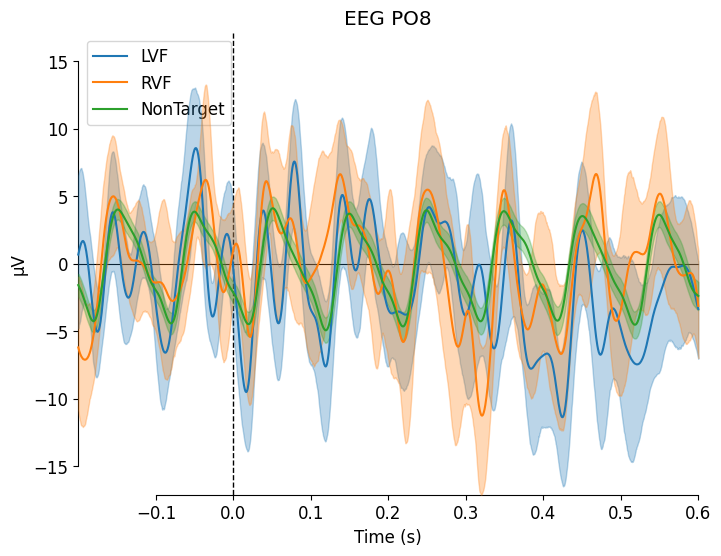

In [184]:
evokeds = dict(LVF=list(all_subj_epochs[0]['targetLVF'].iter_evoked()), RVF=list(all_subj_epochs[0]['targetRVF'].iter_evoked())
               ,NonTarget=list(all_subj_epochs[0]['standard'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=ch[0]);

## **N2pc (200 - 400 ms): Averaging Contralateral - Ipsilateral component**

### Participant averages

In [185]:
all_subj_epochs[1]['targetRVF'].average(picks = 1).info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG PO7
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 28.0 Hz
 meas_date: 2013-02-07 20:42:34 UTC
 nchan: 1
 projs: []
 sfreq: 2048.0 Hz
>

In [186]:
n_ch = int(len(ch)/2)
n_sub = len(all_subj_epochs)
_, _, n_samples = np.shape(all_subj_epochs[1])

contralateral = np.zeros((n_sub,n_ch,n_samples))
ipsilateral = np.zeros((n_sub,n_ch,n_samples))

iter = 0

for count, subj in enumerate(all_subj_epochs):
    
    ch_lbs = []

    for c,_ in enumerate(ch,1):
        if c % 2 == 0 and c <= 8:
            
            if c <= 4:
                
                contralateral[count,iter,:] = (subj['targetLVF'].average(picks = ch[c-2]).get_data() - subj['targetRVF'].average(picks = ch[c-1]).get_data())/2
                ipsilateral[count,iter,:] = (subj['targetRVF'].average(picks = ch[c-2]).get_data() - subj['targetLVF'].average(picks = ch[c-1]).get_data())/2
                
                ch_lbs.append(str(ch[c-2]) + " and " + str(ch[c-1]))

            else:

                contralateral[count,iter,:] = (subj['targetLVF'].average(picks = ch[c-1]).get_data() - subj['targetRVF'].average(picks = ch[c-2]).get_data())/2
                ipsilateral[count,iter,:] = (subj['targetRVF'].average(picks = ch[c-1]).get_data() - subj['targetLVF'].average(picks = ch[c-2]).get_data())/2

                ch_lbs.append(str(ch[c-1]) + " and " + str(ch[c-2]))
                
            iter = iter + 1
        
    iter = 0

In [187]:
np.shape(subj['targetCVF'])

(18, 9, 1640)

In [188]:
ch

['EEG PO8',
 'EEG PO7',
 'EEG P8',
 'EEG P7',
 'EEG O1',
 'EEG O2',
 'EEG PO3',
 'EEG PO4',
 'Status Channel']

In [189]:
subj['targetLVF'].info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG PO8, EEG PO7, EEG P8, EEG P7, EEG O1, EEG O2, EEG PO3, EEG ...
 chs: 9 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 28.0 Hz
 meas_date: 2013-03-15 15:06:50 UTC
 nchan: 9
 projs: []
 sfreq: 2048.0 Hz
>

### Grand-Average

In [190]:
aver_contralateral = np.mean(contralateral, axis = 0)
aver_ipsilateral = np.mean(ipsilateral, axis = 0)

In [191]:
np.shape(subj['targetLVF'])

(14, 9, 1640)

### Plots

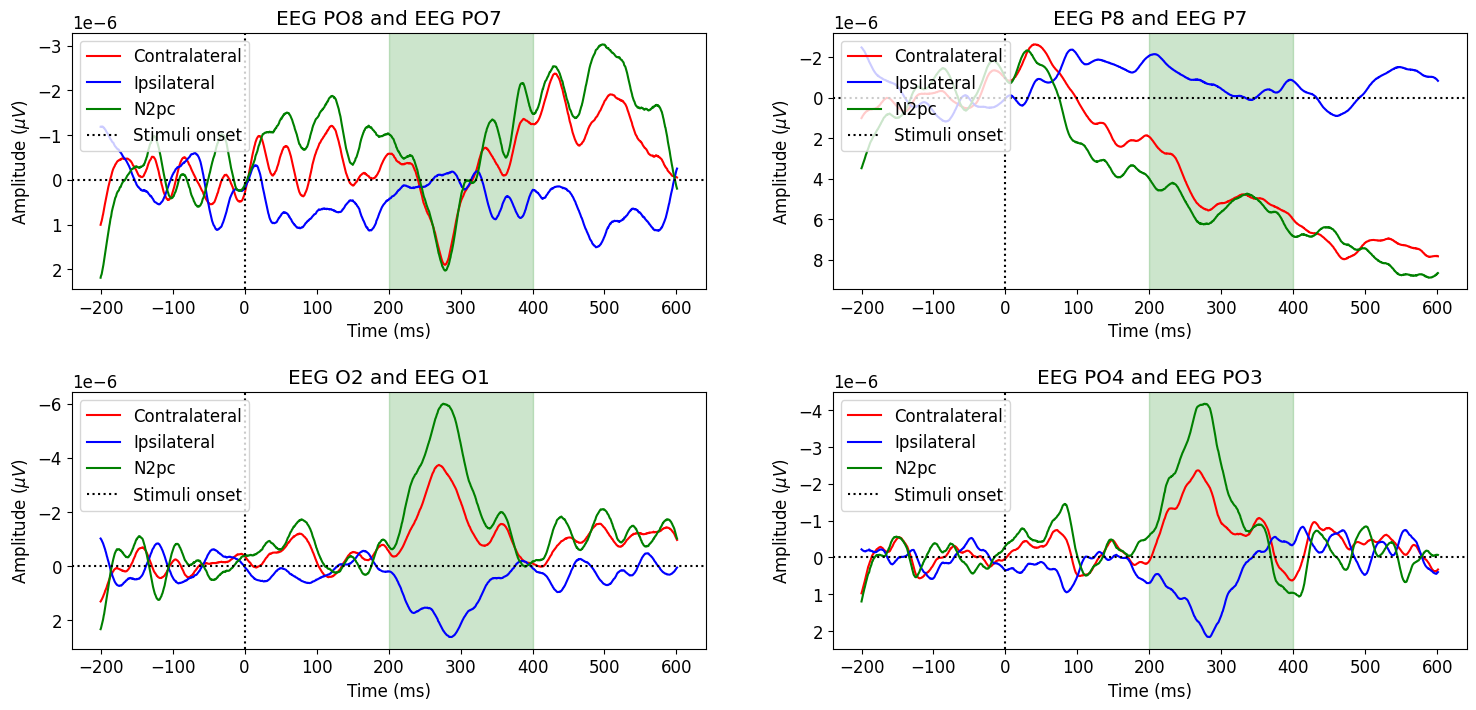

In [192]:
fs = 2048
n_samples = int(len(contralateral[0][0]))
t = ((np.linspace(0,n_samples,n_samples)/fs)*1000) - 200

fig, ax = plt.subplots(figsize=(18, 8), nrows=2, ncols=2)

pos = [[0, 0], [0, 1], [1, 0], [1,1]]

for i in range(n_ch):

    ax[pos[i][0],pos[i][1]].plot(t, aver_contralateral[i],'r', label = 'Contralateral')
    ax[pos[i][0],pos[i][1]].plot(t, aver_ipsilateral[i],'b', label = 'Ipsilateral')
    ax[pos[i][0],pos[i][1]].plot(t, aver_contralateral[i] - aver_ipsilateral[i],'g', label = 'N2pc')
    ax[pos[i][0],pos[i][1]].axvline(x=0, color='k', linestyle='dotted', label = 'Stimuli onset')
    ax[pos[i][0],pos[i][1]].axhline(y=0, color='k', linestyle='dotted')
    ax[pos[i][0],pos[i][1]].invert_yaxis()

    rect = patches.Rectangle((200, -1), 200, 2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.2)
    # - `(200, -1)` is the bottom-left corner of the rectangle (x, y coordinates). Note the y values in the graph are in microVolts
    # - `200` is the width of the rectangle.
    # - `2` is the height of the rectangle.

    ax[pos[i][0],pos[i][1]].add_patch(rect)

    ax[pos[i][0],pos[i][1]].set_title(ch_lbs[i])
    ax[pos[i][0],pos[i][1]].set_xlabel('Time (ms)')
    ax[pos[i][0],pos[i][1]].set_ylabel('Amplitude ($\mu V$)')
    ax[pos[i][0],pos[i][1]].legend(loc='upper left')

plt.subplots_adjust(hspace=0.4)

## **Single trial classification**

### Split the data into Left Visual Field (LVF) and Right Visual Field (RVF) target pictures

In [193]:
np.shape(subj['targetLVF'][1])

(1, 9, 1640)

In [194]:
ch

['EEG PO8',
 'EEG PO7',
 'EEG P8',
 'EEG P7',
 'EEG O1',
 'EEG O2',
 'EEG PO3',
 'EEG PO4',
 'Status Channel']

In [195]:
np.shape(np.squeeze(subj['targetLVF'][2].resample(64).get_data())[4])

(51,)

In [196]:
def slice_tdata(data, tstart, tstop):
    timeVec = np.linspace(-0.2,0.6, len(data))

    ti = np.argmin([abs(t-tstart) for t in timeVec])
    te = np.argmin([abs(t-tstop) for t in timeVec])+1

    sliceddata = data[ti:te]

    return sliceddata

In [197]:
LVF = []
RVF = []

rs = 64
si = 0.2
ss = 0.4

for count, subj in enumerate(all_subj_epochs):

    LVFtrials, _, _ = np.shape(subj['targetLVF'])
    RVFtrials, _, _ = np.shape(subj['targetRVF'])

    subj_LVFtrials = []
    subj_RVFtrials = []

    for c,_ in enumerate(ch,1):
        if c % 2 == 0 and c <= 8:
            
            all_LVFtrials = []
            all_RVFtrials = []
            
            for trial in range(LVFtrials): 
                if c <= 4:
                    aux1 = np.squeeze(subj['targetLVF'][trial].resample(rs).get_data())[c-2] - np.squeeze(subj['targetLVF'][trial].resample(rs).get_data())[c-1]
                else:
                    aux1 = np.squeeze(subj['targetLVF'][trial].resample(rs).get_data())[c-1] - np.squeeze(subj['targetLVF'][trial].resample(rs).get_data())[c-2]
                
                n_aux1 = slice_tdata(aux1, si, ss)
                        
                all_LVFtrials.append(n_aux1)

            for trial in range(RVFtrials): 
                if c <= 4:
                    aux2 = np.squeeze(subj['targetRVF'][trial].resample(rs).get_data())[c-1] - np.squeeze(subj['targetRVF'][trial].resample(rs).get_data())[c-2]
                else:
                    aux2 = np.squeeze(subj['targetRVF'][trial].resample(rs).get_data())[c-2] - np.squeeze(subj['targetRVF'][trial].resample(rs).get_data())[c-1]
                
                n_aux2 = slice_tdata(aux2, si, ss)

                all_RVFtrials.append(n_aux2)

            subj_LVFtrials.append(all_LVFtrials)
            subj_RVFtrials.append(all_RVFtrials)

    LVF.append(subj_LVFtrials)
    RVF.append(subj_RVFtrials)

In [198]:
print(np.shape(LVF[0]))
print(np.shape(RVF[0]))

(4, 15, 14)
(4, 14, 14)


In [199]:
np.shape(LVF[0][0]) # [ch, trial, feat]

(15, 14)

### Train/Test Split and concatenate feature vectors for all channel differences 

In [200]:
def split_featVec_EEG(subject_EEG, percent_train=0.75):

    # Splits each subject EEG into train and test data but also prepares the feature vectors for Classification

    n_ch, n_trials, n_feat = np.shape(subject_EEG)
    n_train = round(n_trials * percent_train)
    n_test = n_trials - n_train

    bf_split = np.zeros((n_trials,n_ch*n_feat))

    ## Concatenation                    
    # hstack concatenates data horizontally, i.e., by columns

    for trial in range(n_trials):
        for ch in range(1,n_ch):
            if ch == 1:
                aux = np.hstack((subject_EEG[ch-1][trial],subject_EEG[ch][trial]))
            else:
                aux = np.hstack((aux,subject_EEG[ch][trial]))
        
        bf_split[trial] = aux

    ## Split

    train = bf_split[:n_train]
    test  = bf_split[n_train:n_train+n_test] 

    return train, test

all_train_LVF = []
all_train_RVF = [] 

all_test_LVF = [] 
all_test_RVF = [] 

for subj in range(len(all_subj_epochs)):
    train_LVF, test_LVF = split_featVec_EEG(LVF[subj])
    train_RVF, test_RVF = split_featVec_EEG(RVF[subj])

    ntrials_train_LVF, _ = np.shape(train_LVF)
    ntrials_train_RVF, _ = np.shape(train_RVF)
    ntrials_test_LVF, _ = np.shape(test_LVF)
    ntrials_test_RVF, _ = np.shape(test_RVF)

    all_train_LVF.append(np.hstack((train_LVF,np.ones((ntrials_train_LVF,1)))))
    all_test_LVF.append(np.hstack((test_LVF,np.ones((ntrials_test_LVF,1)))))

    all_train_RVF.append(np.hstack((train_RVF,np.zeros((ntrials_train_RVF,1)))))
    all_test_RVF.append(np.hstack((test_RVF,np.zeros((ntrials_test_RVF,1)))))
        

### Classification (Training in Red and Testing in Green)

#### SVM

In [201]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import random

kfold = 10
n_feat = len(np.squeeze(all_test_LVF[0][0]))-1
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

perKernel_predicted_labels = []
perKernel_cross_val_scores = []
perKernel_auc_scores = []

all_test = []

for kernel in kernels:

    test = []

    perSubj_predicted_labels = []
    perSubj_auc_scores = []
    perSubj_cross_val_scores = np.zeros((len(all_subj_epochs),2))

    for subj in range(len(all_subj_epochs)):
        clf = SVC(kernel=kernel, probability=True)

        train = np.vstack((all_train_LVF[subj], all_train_RVF[subj]))
        test.append(np.vstack((all_test_LVF[subj], all_test_RVF[subj])))

        random.seed(42)
        np.random.shuffle(train) # Randomiza a ordem
        random.seed(42)
        np.random.shuffle(test[subj])

        scores = cross_val_score(clf, train[:,0:n_feat], train[:,n_feat], cv=kfold)
        clf.fit(train[:,0:n_feat], train[:,n_feat])
        perSubj_predicted_labels.append(clf.predict(test[subj][:,0:n_feat]))

        # Compute AUC for each subject
        perSubj_auc_scores.append(roc_auc_score(test[subj][:, n_feat], clf.predict_proba(test[subj][:, 0:n_feat])[:, 1]))

        perSubj_cross_val_scores[subj,0] = (scores.mean() * 100)
        perSubj_cross_val_scores[subj,1] = (scores.std() * 100)

    perKernel_cross_val_scores.append(perSubj_cross_val_scores)
    perKernel_predicted_labels.append(perSubj_predicted_labels)

    perKernel_auc_scores.append(perSubj_auc_scores)

    all_test.append(test)

# Access the AUC scores for each classifier and kernel
for kernel, auc_scores in zip(kernels, perKernel_auc_scores):
    print(f"AUC scores for {kernel} kernel:")
    for subj, auc_score in enumerate(auc_scores):
        print(f"Subject {subj + 1}: {auc_score}")

c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


AUC scores for linear kernel:
Subject 1: 0.5
Subject 2: 0.0625
Subject 3: 0.5
Subject 4: 0.22222222222222224
Subject 5: 0.125
Subject 6: 0.5
Subject 7: 0.75
Subject 8: 0.5
Subject 9: 0.0
Subject 10: 0.5
AUC scores for poly kernel:
Subject 1: 0.0625
Subject 2: 0.8125
Subject 3: 0.3333333333333333
Subject 4: 0.33333333333333337
Subject 5: 0.28125
Subject 6: 0.6666666666666667
Subject 7: 0.4375
Subject 8: 0.3125
Subject 9: 0.0625
Subject 10: 0.0
AUC scores for rbf kernel:
Subject 1: 0.875
Subject 2: 0.875
Subject 3: 0.33333333333333337
Subject 4: 0.22222222222222224
Subject 5: 0.8125
Subject 6: 0.4166666666666667
Subject 7: 0.4375
Subject 8: 0.875
Subject 9: 0.9375
Subject 10: 0.7500000000000001
AUC scores for sigmoid kernel:
Subject 1: 0.8125
Subject 2: 0.9375
Subject 3: 0.33333333333333337
Subject 4: 0.888888888888889
Subject 5: 0.875
Subject 6: 0.5833333333333334
Subject 7: 0.78125
Subject 8: 1.0
Subject 9: 0.9375
Subject 10: 0.25


In [202]:
np.mean(perKernel_auc_scores, axis = 1)

array([0.36597222, 0.33020833, 0.65347222, 0.73993056])

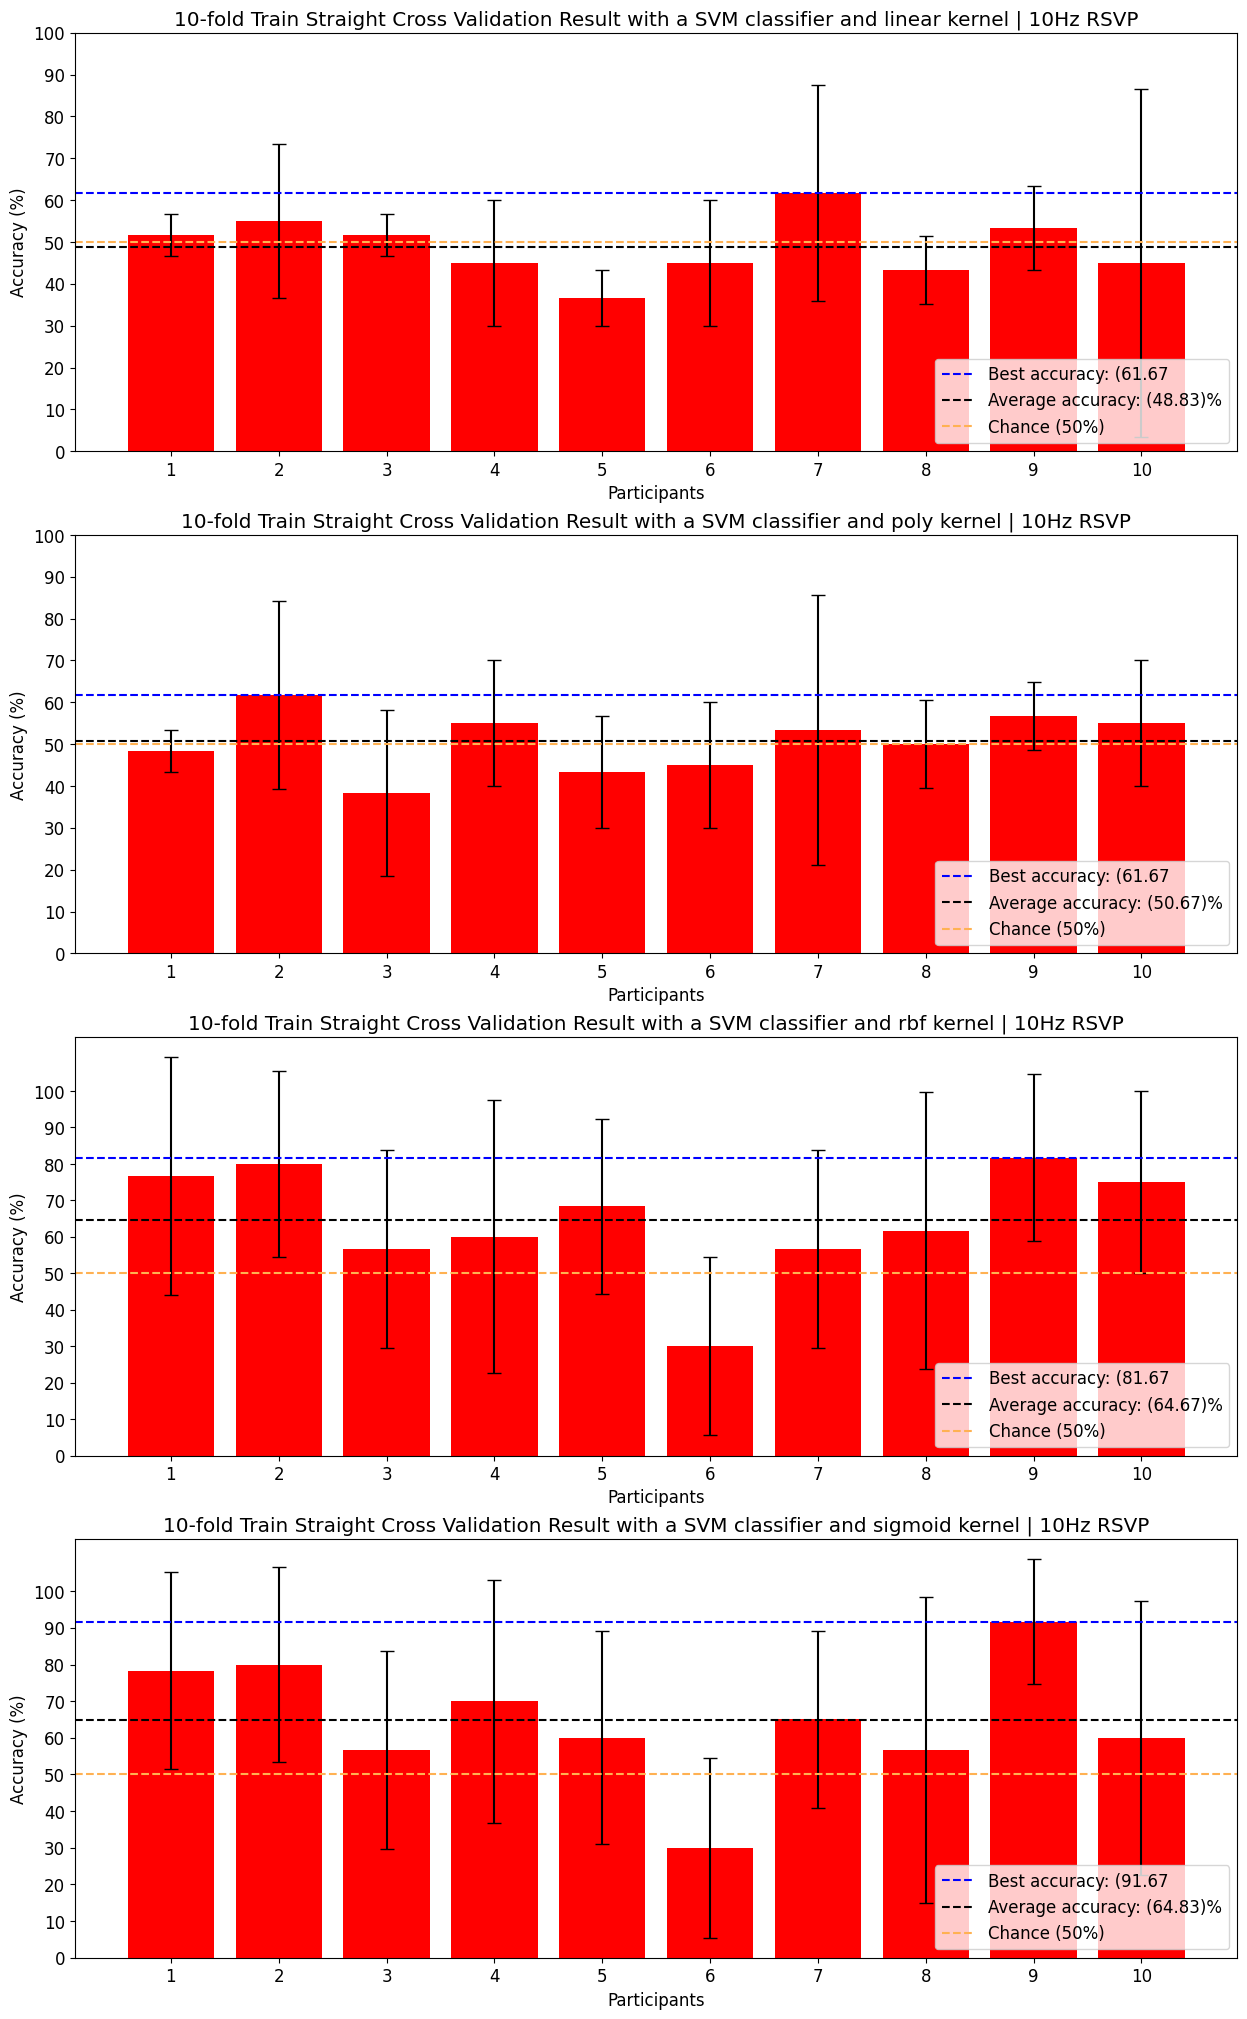

In [203]:
fig, axs = plt.subplots(nrows=len(kernels), ncols=1, figsize=(15, 25))

for count, kernel in enumerate(kernels):

       idx = np.argmax(perKernel_cross_val_scores[count][:,0]) # Indice da melhor acuracia

       ax = axs[count]

       plt.rcParams.update({'font.size': 12})
       ax.set_title('Accuracy (%)')
       ax.bar(np.arange(1, len(all_subj_epochs)+1), perKernel_cross_val_scores[count][:,0], color="red", yerr=perKernel_cross_val_scores[count][:,1], capsize=5)
       ax.axhline(y=perKernel_cross_val_scores[count][idx,0], color='blue', linestyle='--', label = f'Best accuracy: ({perKernel_cross_val_scores[count][idx,0]:.2f}')
       ax.axhline(y=np.mean(perKernel_cross_val_scores[count][:,0]), color='k', linestyle='--', label = f'Average accuracy: ({np.mean(perKernel_cross_val_scores[count][:,0]):.2f})%')
       ax.axhline(y=50, color='#ffb152', linestyle='--', label = 'Chance (50%)')
       ax.set(xticks=np.arange(1, len(all_subj_epochs)+1), xlabel='Participants', 
              yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
              title=f'{kfold}-fold Train Straight Cross Validation Result with a SVM classifier and {kernel} kernel | {exp1} RSVP');
       ax.legend(loc='lower right')

plt.subplots_adjust(hspace=0.2)


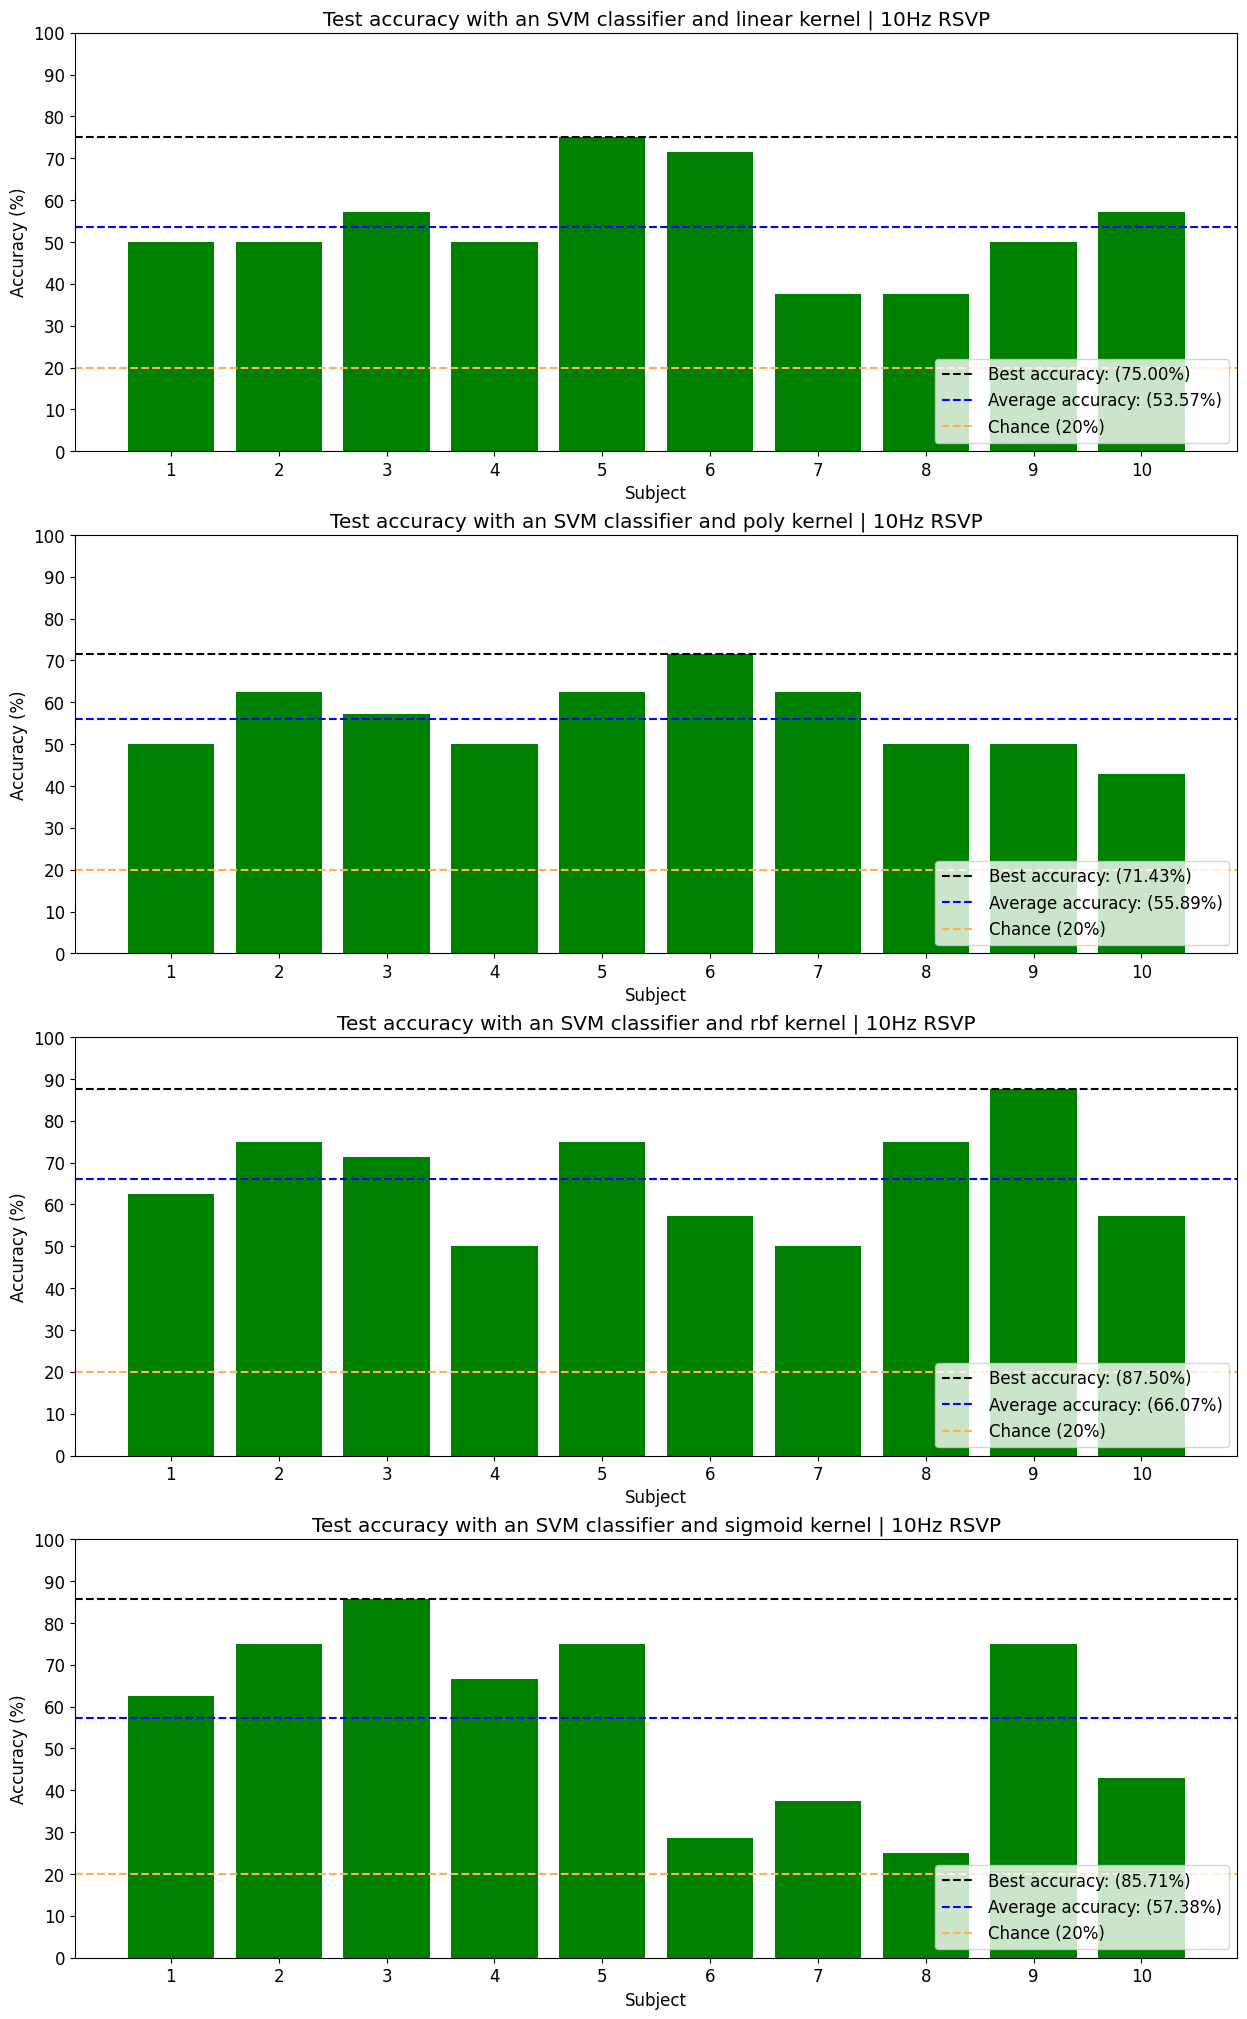

In [204]:
from sklearn.metrics import accuracy_score

all_acc_kernel = np.zeros((len(kernels),len(all_subj_epochs)))
mean_acc = np.zeros((len(kernels),1))

for kernel, _ in enumerate(kernels):

  all_acc = np.zeros(len(all_subj_epochs))

  for subj in range(len(all_subj_epochs)):

    acc = accuracy_score(all_test[kernel][subj][:,n_feat],perKernel_predicted_labels[kernel][subj]) * 100
    all_acc[subj] = acc 

    #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

  mean_acc[kernel] = np.mean(all_acc)
  all_acc_kernel[kernel,:] = all_acc

fig, axs = plt.subplots(nrows=len(kernels), ncols=1, figsize=(15, 25))

for count, kernel in enumerate(kernels):
    ax = axs[count]

    idx = np.argmax(mean_acc)  # Index of the highest accuracy

    plt.rcParams.update({'font.size': 12})
    ax.set_title('Accuracy (%)')
    ax.bar(np.arange(1, len(all_subj_epochs) + 1), all_acc_kernel[count], color="green", capsize=5)
    ax.axhline(y=max(all_acc_kernel[count]), color='k', linestyle='--', label=f'Best accuracy: ({max(all_acc_kernel[count]):.2f}%)')
    ax.axhline(y=mean_acc[count], color='blue', linestyle='--', label=f'Average accuracy: ({float(mean_acc[count]):.2f}%)')
    ax.axhline(y=20, color='#ffb152', linestyle='--', label='Chance (20%)')
    ax.set(
        xticks=np.arange(1, len(all_subj_epochs) + 1),
        xlabel='Subject',
        yticks=np.arange(0, 101, step=10),
        ylabel='Accuracy (%)',
        title=f'Test accuracy with an SVM classifier and {kernel} kernel | {exp1} RSVP'
    )
    ax.legend(loc='lower right')


#### LDA

In [205]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

solvers = ['svd', 'lsqr']

perKernel_predicted_labels = []
perKernel_cross_val_scores = []
perKernel_auc_scores = []

for kernel in solvers:

    perSubj_predicted_labels = []
    perSubj_cross_val_scores = np.zeros((len(all_subj_epochs),2))
    perSubj_auc_scores = []

    test = []

    for subj in range(len(all_subj_epochs)):
        clf = LDA(solver=kernel)

        train = np.vstack((all_train_LVF[subj], all_train_RVF[subj]))
        test.append(np.vstack((all_test_LVF[subj], all_test_RVF[subj])))

        random.seed(42)
        np.random.shuffle(train) # Randomiza a ordem
        random.seed(42)
        np.random.shuffle(test[subj])

        scores = cross_val_score(clf, train[:,0:n_feat], train[:,n_feat], cv=kfold)
        clf.fit(train[:,0:n_feat], train[:,n_feat])
        perSubj_predicted_labels.append(clf.predict(test[subj][:,0:n_feat]))

        perSubj_auc_scores.append(roc_auc_score(test[subj][:, n_feat], clf.predict_proba(test[subj][:, 0:n_feat])[:, 1]))

        perSubj_cross_val_scores[subj,0] = (scores.mean() * 100)
        perSubj_cross_val_scores[subj,1] = (scores.std() * 100)

    perKernel_cross_val_scores.append(perSubj_cross_val_scores)
    perKernel_predicted_labels.append(perSubj_predicted_labels)

    perKernel_auc_scores.append(perSubj_auc_scores)

# Access the AUC scores for each classifier and kernel
for kernel, auc_scores in zip(solvers, perKernel_auc_scores):
    print(f"AUC scores for {kernel} kernel:")
    for subj, auc_score in enumerate(auc_scores):
        print(f"Subject {subj + 1}: {auc_score}")


c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


AUC scores for svd kernel:
Subject 1: 0.5625
Subject 2: 0.9375
Subject 3: 0.9166666666666667
Subject 4: 0.7777777777777779
Subject 5: 0.875
Subject 6: 0.6666666666666667
Subject 7: 0.5625
Subject 8: 1.0
Subject 9: 0.875
Subject 10: 1.0
AUC scores for lsqr kernel:
Subject 1: 0.6875
Subject 2: 1.0
Subject 3: 0.7500000000000001
Subject 4: 0.7777777777777779
Subject 5: 0.375
Subject 6: 0.4166666666666667
Subject 7: 0.625
Subject 8: 1.0
Subject 9: 0.875
Subject 10: 1.0


In [206]:
np.mean(perKernel_auc_scores, axis = 1)

array([0.81736111, 0.75069444])

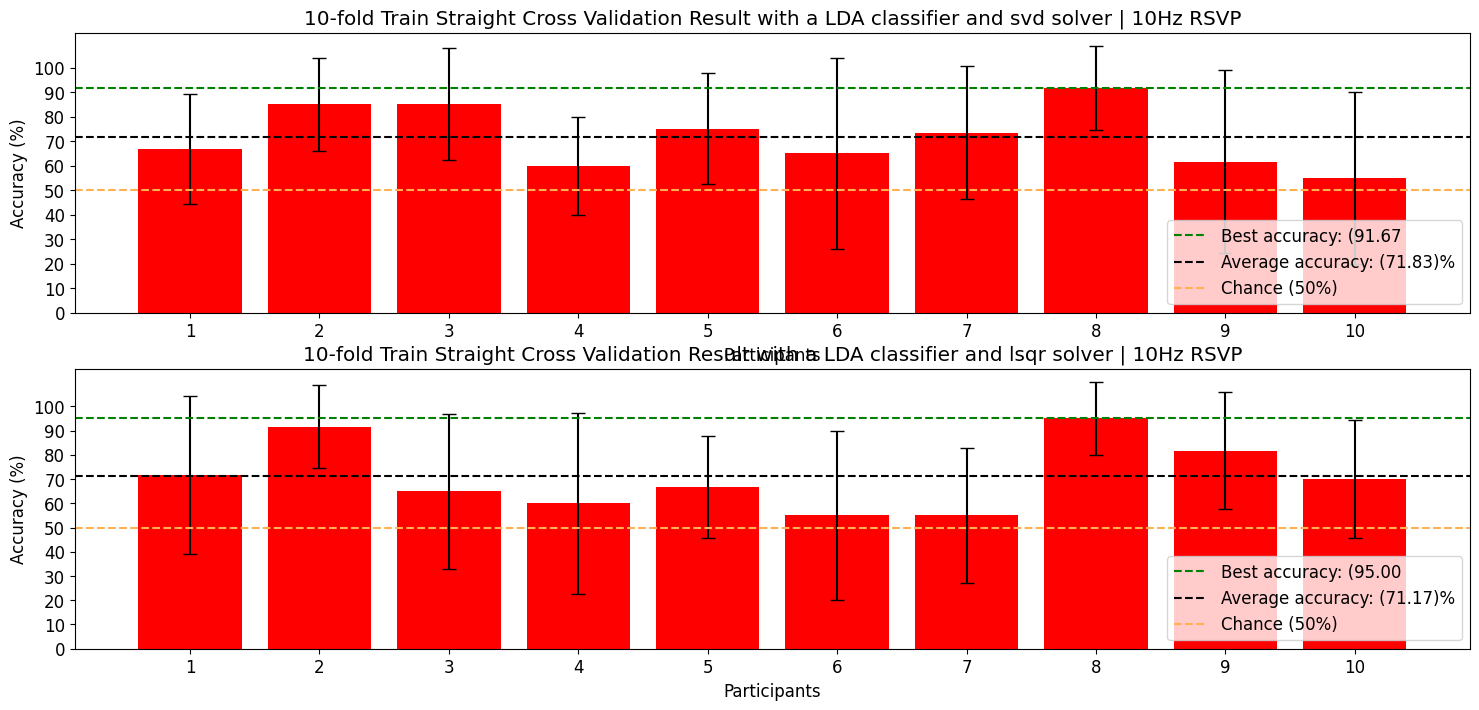

In [207]:
fig, axs = plt.subplots(nrows=len(solvers), ncols=1, figsize=(18, 8))

for count, solver in enumerate(solvers):

       idx = np.argmax(perKernel_cross_val_scores[count][:,0]) # Indice da melhor acuracia

       ax = axs[count]

       plt.rcParams.update({'font.size': 12})
       ax.set_title('Accuracy (%)')
       ax.bar(np.arange(1, len(all_subj_epochs)+1), perKernel_cross_val_scores[count][:,0], color="red", yerr=perKernel_cross_val_scores[count][:,1], capsize=5)
       ax.axhline(y=perKernel_cross_val_scores[count][idx,0], color='green', linestyle='--', label = f'Best accuracy: ({perKernel_cross_val_scores[count][idx,0]:.2f}')
       ax.axhline(y=np.mean(perKernel_cross_val_scores[count][:,0]), color='k', linestyle='--', label = f'Average accuracy: ({np.mean(perKernel_cross_val_scores[count][:,0]):.2f})%')
       ax.axhline(y=50, color='#ffb152', linestyle='--', label = 'Chance (50%)')
       ax.set(xticks=np.arange(1, len(all_subj_epochs)+1), xlabel='Participants', 
              yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
              title=f'{kfold}-fold Train Straight Cross Validation Result with a LDA classifier and {solver} solver | {exp1} RSVP');
       ax.legend(loc='lower right');

plt.subplots_adjust(hspace=0.2)

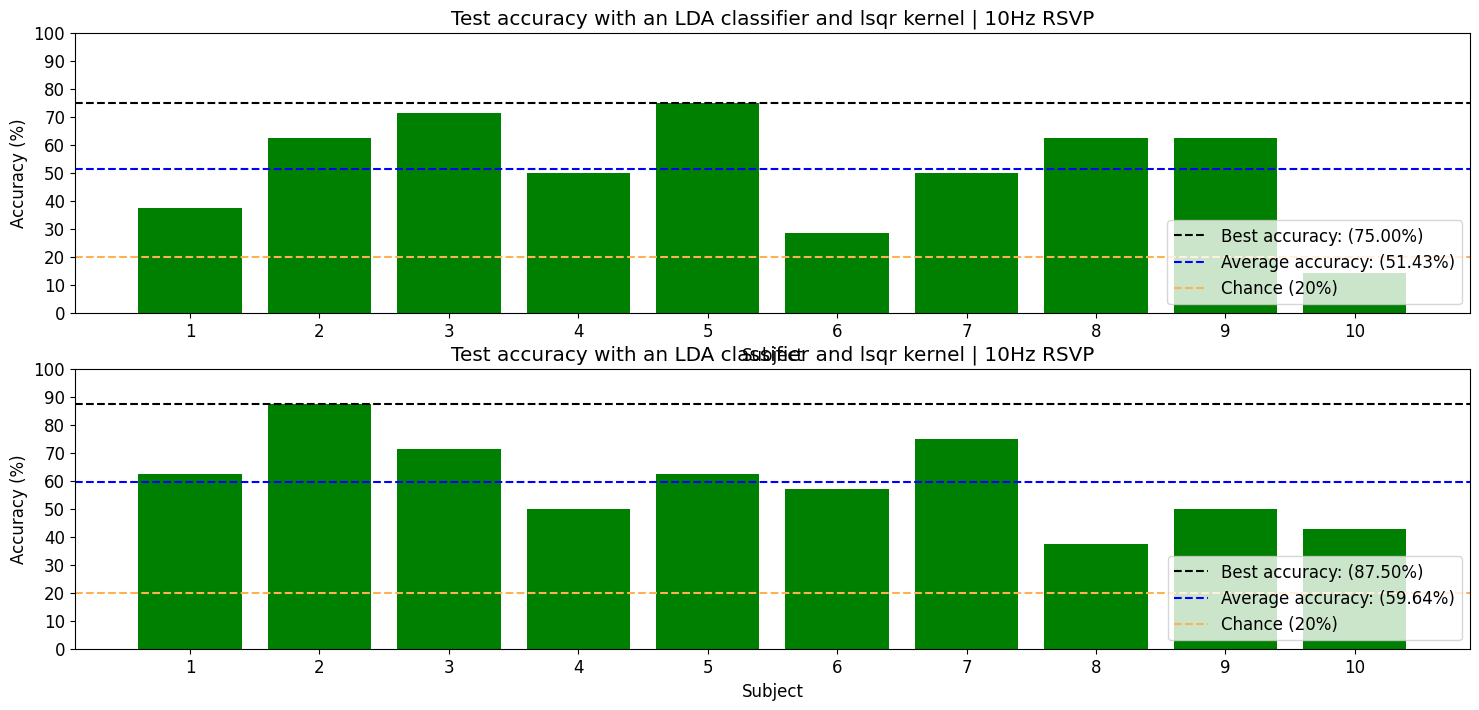

In [208]:
all_acc_kernel = np.zeros((len(solvers),len(all_subj_epochs)))
mean_acc = np.zeros((len(solvers),1))

for kernel, _ in enumerate(solvers):

  all_acc = np.zeros(len(all_subj_epochs))

  for subj in range(len(all_subj_epochs)):

    acc = accuracy_score(all_test[kernel][subj][:,n_feat],perKernel_predicted_labels[kernel][subj]) * 100
    all_acc[subj] = acc 

    #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

  mean_acc[kernel] = np.mean(all_acc)
  all_acc_kernel[kernel,:] = all_acc

fig, axs = plt.subplots(nrows=len(solvers), ncols=1, figsize=(18, 8))

for count, kernel in enumerate(solvers):
    ax = axs[count]

    idx = np.argmax(mean_acc)  # Index of the highest accuracy

    plt.rcParams.update({'font.size': 12})
    ax.set_title('Accuracy (%)')
    ax.bar(np.arange(1, len(all_subj_epochs) + 1), all_acc_kernel[count], color="green", capsize=5)
    ax.axhline(y=max(all_acc_kernel[count]), color='k', linestyle='--', label=f'Best accuracy: ({max(all_acc_kernel[count]):.2f}%)')
    ax.axhline(y=mean_acc[count], color='blue', linestyle='--', label=f'Average accuracy: ({float(mean_acc[count]):.2f}%)')
    ax.axhline(y=20, color='#ffb152', linestyle='--', label='Chance (20%)')
    ax.set(
        xticks=np.arange(1, len(all_subj_epochs) + 1),
        xlabel='Subject',
        yticks=np.arange(0, 101, step=10),
        ylabel='Accuracy (%)',
        title=f'Test accuracy with an LDA classifier and {solver} kernel | {exp1} RSVP'
    )
    ax.legend(loc='lower right')


### Random Forest

In [209]:
from sklearn.ensemble import RandomForestClassifier

all_test = []

perSubj_predicted_labels = []
perSubj_cross_val_scores = np.zeros((len(all_subj_epochs), 2))
perSubj_auc_scores = []

for subj in range(len(all_subj_epochs)):
    clf = RandomForestClassifier()  # Create an instance of Random Forest classifier

    train = np.vstack((all_train_LVF[subj], all_train_RVF[subj]))
    test = np.vstack((all_test_LVF[subj], all_test_RVF[subj]))

    random.seed(42)
    np.random.shuffle(train)  # Randomize the order
    random.seed(42)
    np.random.shuffle(test)

    scores = cross_val_score(clf, train[:, 0:n_feat], train[:, n_feat], cv=kfold)
    clf.fit(train[:, 0:n_feat], train[:, n_feat])
    perSubj_predicted_labels.append(clf.predict(test[:, 0:n_feat]))

    perSubj_auc_scores.append(roc_auc_score(test[:, n_feat], clf.predict_proba(test[:, 0:n_feat])[:, 1]))

    perSubj_cross_val_scores[subj, 0] = (scores.mean() * 100)
    perSubj_cross_val_scores[subj, 1] = (scores.std() * 100)

    all_test.append(test)

c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


In [210]:
perSubj_auc_scores

[0.9375,
 0.8125,
 0.5416666666666666,
 0.3888888888888889,
 0.9375,
 0.25,
 0.5,
 0.71875,
 1.0,
 0.7500000000000001]

In [211]:
np.mean(perSubj_auc_scores)

0.6836805555555555

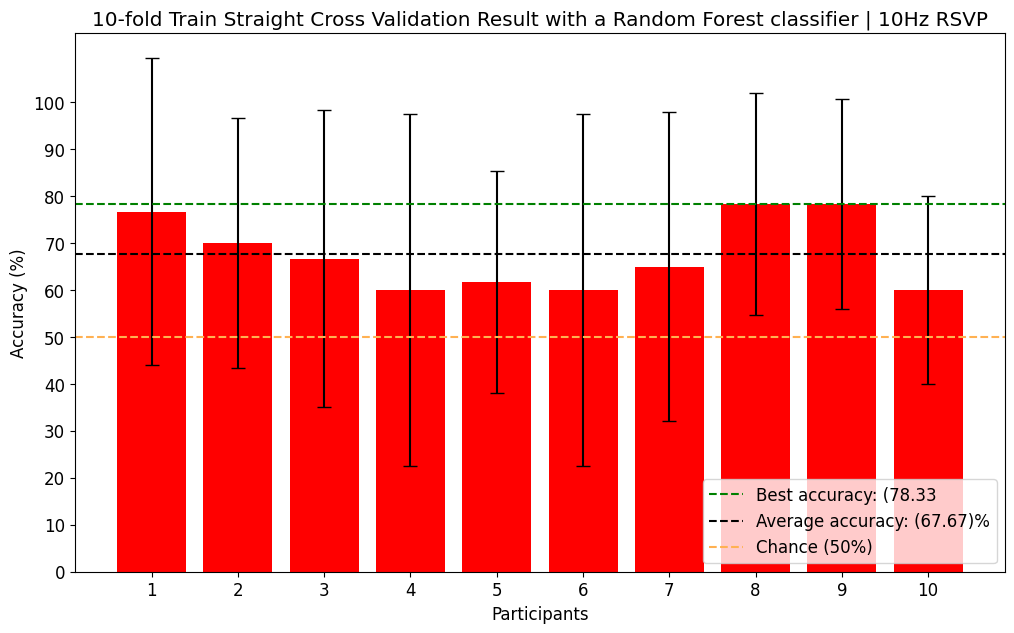

In [212]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_subj_epochs)+1), perSubj_cross_val_scores[:,0], color="red", yerr=perSubj_cross_val_scores[:,1], capsize=5)
ax.axhline(y=max(perSubj_cross_val_scores[:,0]), color='green', linestyle='--', label = f'Best accuracy: ({max(perSubj_cross_val_scores[:,0]):.2f}')
ax.axhline(y=np.mean(perSubj_cross_val_scores[:,0]), color='k', linestyle='--', label = f'Average accuracy: ({np.mean(perSubj_cross_val_scores[:,0]):.2f})%')
ax.axhline(y=50, color='#ffb152', linestyle='--', label = 'Chance (50%)')
ax.set(xticks=np.arange(1, len(all_subj_epochs)+1), xlabel='Participants', 
              yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
              title=f'{kfold}-fold Train Straight Cross Validation Result with a Random Forest classifier | {exp1} RSVP');
ax.legend(loc='lower right');

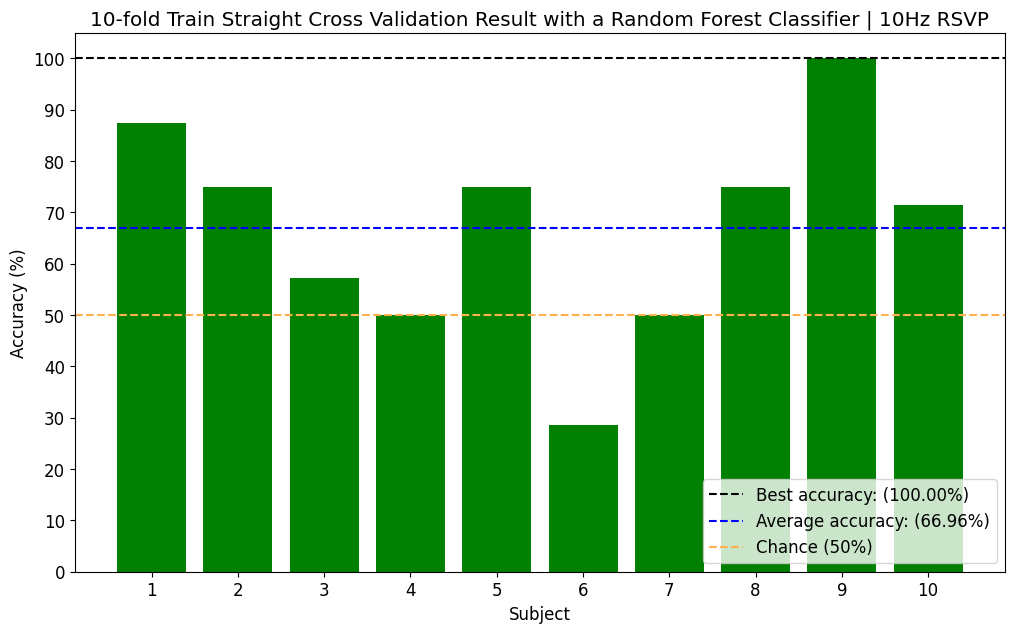

In [213]:
all_acc = np.zeros(len(all_subj_epochs))

for subj in range(len(all_subj_epochs)):

    acc = accuracy_score(all_test[subj][:,n_feat],perSubj_predicted_labels[subj]) * 100
    all_acc[subj] = acc 

#print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

fig, ax = plt.subplots(figsize=(12, 7))

idx = np.argmax(mean_acc)  # Index of the highest accuracy

plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_subj_epochs) + 1), all_acc, color="green", capsize=5)
ax.axhline(y=max(all_acc), color='k', linestyle='--', label=f'Best accuracy: ({max(all_acc):.2f}%)')
ax.axhline(y=np.mean(all_acc), color='blue', linestyle='--', label=f'Average accuracy: ({np.mean(all_acc):.2f}%)')
ax.axhline(y=50, color='#ffb152', linestyle='--', label='Chance (50%)')
ax.set(
    xticks=np.arange(1, len(all_subj_epochs) + 1),
    xlabel='Subject',
    yticks=np.arange(0, 101, step=10),
    ylabel='Accuracy (%)',
    title=f'{kfold}-fold Train Straight Cross Validation Result with a Random Forest Classifier | {exp1} RSVP'
)
ax.legend(loc='lower right')

### XGBoost

In [214]:
import xgboost as xgb

all_test = []

perSubj_predicted_labels = []
perSubj_cross_val_scores = np.zeros((len(all_subj_epochs), 2))
perSubj_auc_scores = []

for subj in range(len(all_subj_epochs)):
    clf = xgb.XGBClassifier()  # Create an instance of XGBoost classifier

    train = np.vstack((all_train_LVF[subj], all_train_RVF[subj]))
    test = np.vstack((all_test_LVF[subj], all_test_RVF[subj]))

    random.seed(42)
    np.random.shuffle(train)  # Randomize the order
    random.seed(42)
    np.random.shuffle(test)

    scores = cross_val_score(clf, train[:, 0:n_feat], train[:, n_feat], cv=kfold)
    clf.fit(train[:, 0:n_feat], train[:, n_feat])
    perSubj_predicted_labels.append(clf.predict(test[:, 0:n_feat]))

    perSubj_auc_scores.append(roc_auc_score(test[:, n_feat], clf.predict_proba(test[:, 0:n_feat])[:, 1]))

    perSubj_cross_val_scores[subj, 0] = (scores.mean() * 100)
    perSubj_cross_val_scores[subj, 1] = (scores.std() * 100)

    all_test.append(test)

c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


In [215]:
perSubj_auc_scores

[0.8125,
 0.9375,
 0.5,
 0.7777777777777779,
 0.6875,
 0.6666666666666667,
 0.375,
 0.4375,
 1.0,
 0.6666666666666666]

In [216]:
np.mean(perSubj_auc_scores)

0.6861111111111111

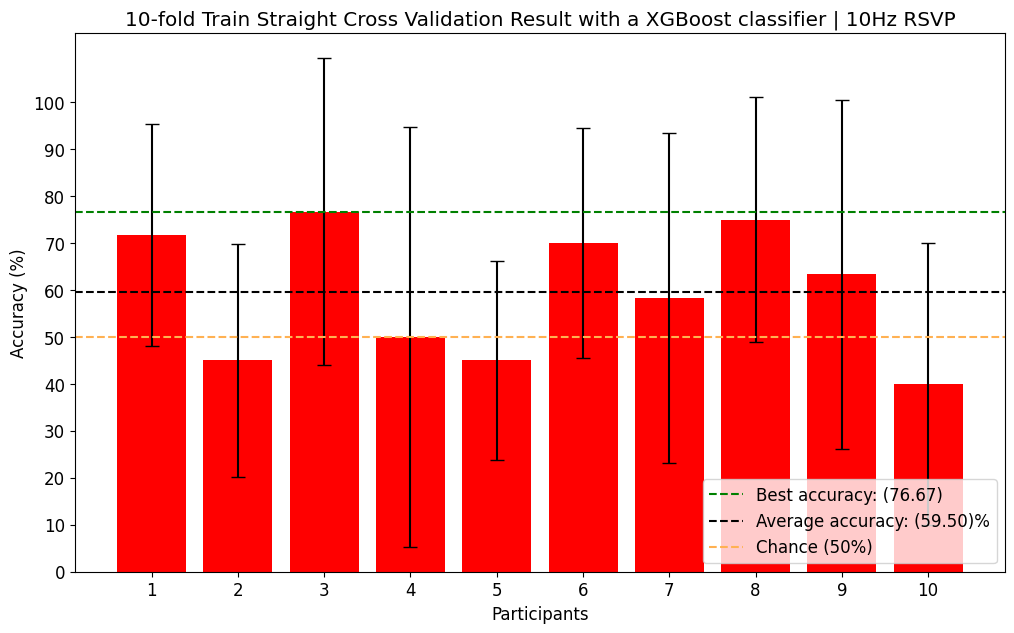

In [217]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_subj_epochs)+1), perSubj_cross_val_scores[:,0], color="red", yerr=perSubj_cross_val_scores[:,1], capsize=5)
ax.axhline(y=max(perSubj_cross_val_scores[:,0]), color='green', linestyle='--', label = f'Best accuracy: ({max(perSubj_cross_val_scores[:,0]):.2f})')
ax.axhline(y=np.mean(perSubj_cross_val_scores[:,0]), color='k', linestyle='--', label = f'Average accuracy: ({np.mean(perSubj_cross_val_scores[:,0]):.2f})%')
ax.axhline(y=50, color='#ffb152', linestyle='--', label = 'Chance (50%)')
ax.set(xticks=np.arange(1, len(all_subj_epochs)+1), xlabel='Participants', 
              yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
              title=f'{kfold}-fold Train Straight Cross Validation Result with a XGBoost classifier | {exp1} RSVP');
ax.legend(loc='lower right');

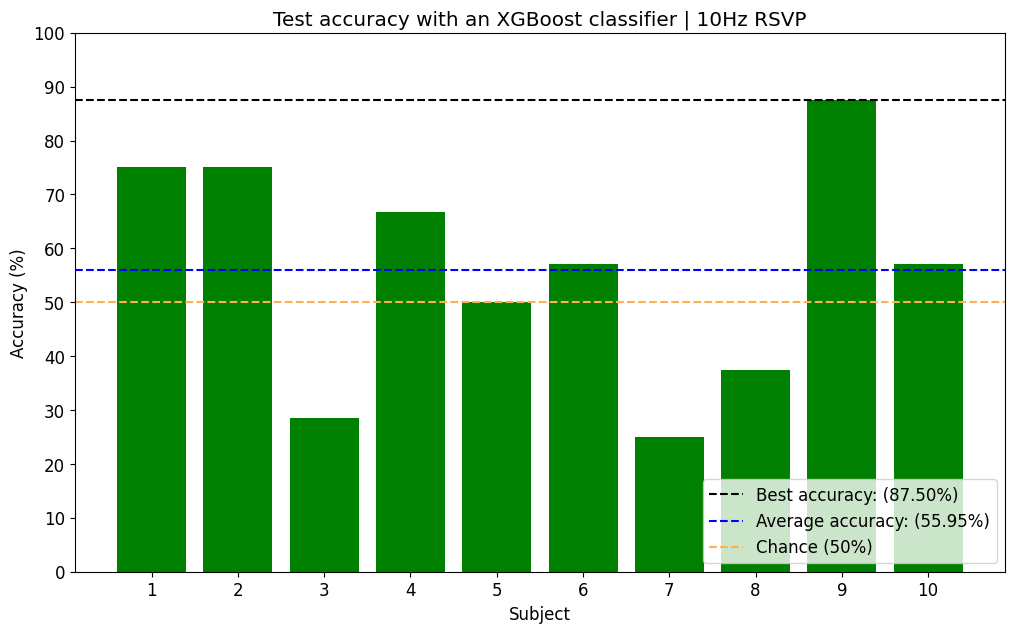

In [218]:
all_acc = np.zeros(len(all_subj_epochs))

for subj in range(len(all_subj_epochs)):

    acc = accuracy_score(all_test[subj][:,n_feat],perSubj_predicted_labels[subj]) * 100
    all_acc[subj] = acc 

#print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

fig, ax = plt.subplots(figsize=(12, 7))

idx = np.argmax(mean_acc)  # Index of the highest accuracy

plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_subj_epochs) + 1), all_acc, color="green", capsize=5)
ax.axhline(y=max(all_acc), color='k', linestyle='--', label=f'Best accuracy: ({max(all_acc):.2f}%)')
ax.axhline(y=np.mean(all_acc), color='blue', linestyle='--', label=f'Average accuracy: ({np.mean(all_acc):.2f}%)')
ax.axhline(y=50, color='#ffb152', linestyle='--', label='Chance (50%)')
ax.set(
    xticks=np.arange(1, len(all_subj_epochs) + 1),
    xlabel='Subject',
    yticks=np.arange(0, 101, step=10),
    ylabel='Accuracy (%)',
    title=f'Test accuracy with an XGBoost classifier | {exp1} RSVP'
)
ax.legend(loc='lower right')

In [219]:
from sklearn.ensemble import AdaBoostClassifier

all_test = []

perSubj_predicted_labels = []
perSubj_cross_val_scores = np.zeros((len(all_subj_epochs), 2))
perSubj_auc_scores = []

for subj in range(len(all_subj_epochs)):
    clf = AdaBoostClassifier()  # Create an instance of AdaBoost classifier

    train = np.vstack((all_train_LVF[subj], all_train_RVF[subj]))
    test = np.vstack((all_test_LVF[subj], all_test_RVF[subj]))

    random.seed(42)
    np.random.shuffle(train)  # Randomize the order
    random.seed(42)
    np.random.shuffle(test)

    scores = cross_val_score(clf, train[:, 0:n_feat], train[:, n_feat], cv=kfold)
    clf.fit(train[:, 0:n_feat], train[:, n_feat])
    perSubj_predicted_labels.append(clf.predict(test[:, 0:n_feat]))

    perSubj_auc_scores.append(roc_auc_score(test[:, n_feat], clf.predict_proba(test[:, 0:n_feat])[:, 1]))

    perSubj_cross_val_scores[subj, 0] = (scores.mean() * 100)
    perSubj_cross_val_scores[subj, 1] = (scores.std() * 100)

    all_test.append(test)

c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


In [220]:
perSubj_auc_scores

[0.875,
 0.9375,
 0.5,
 0.22222222222222224,
 0.75,
 0.5,
 0.5625,
 0.625,
 0.9375,
 0.41666666666666663]

In [221]:
np.mean(perSubj_auc_scores)

0.632638888888889

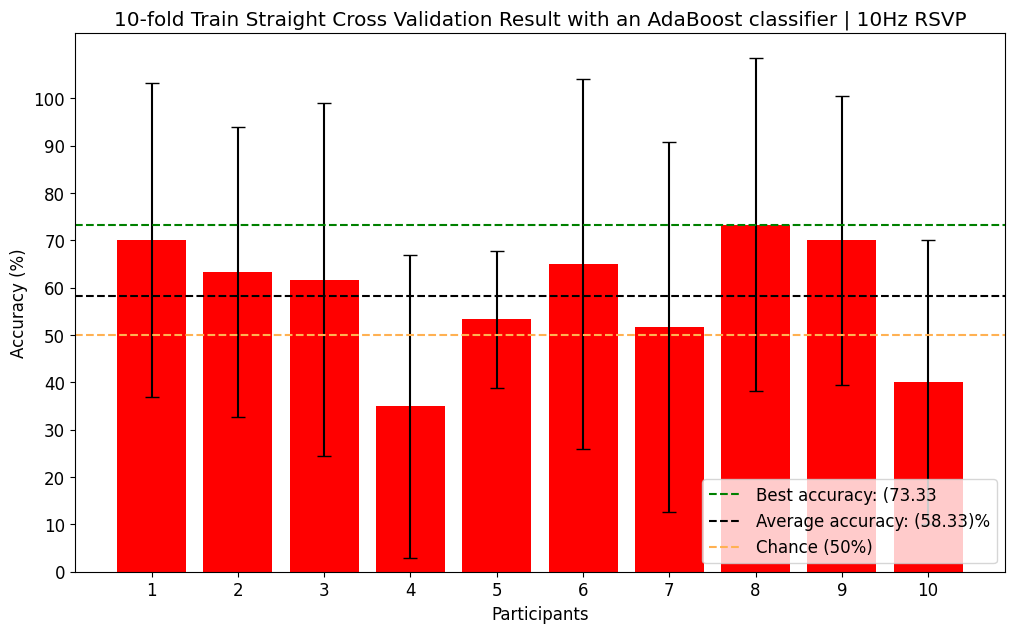

In [222]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_subj_epochs)+1), perSubj_cross_val_scores[:,0], color="red", yerr=perSubj_cross_val_scores[:,1], capsize=5)
ax.axhline(y=max(perSubj_cross_val_scores[:,0]), color='green', linestyle='--', label = f'Best accuracy: ({max(perSubj_cross_val_scores[:,0]):.2f}')
ax.axhline(y=np.mean(perSubj_cross_val_scores[:,0]), color='k', linestyle='--', label = f'Average accuracy: ({np.mean(perSubj_cross_val_scores[:,0]):.2f})%')
ax.axhline(y=50, color='#ffb152', linestyle='--', label = 'Chance (50%)')
ax.set(xticks=np.arange(1, len(all_subj_epochs)+1), xlabel='Participants', 
              yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
              title=f'{kfold}-fold Train Straight Cross Validation Result with an AdaBoost classifier | {exp1} RSVP');
ax.legend(loc='lower right');

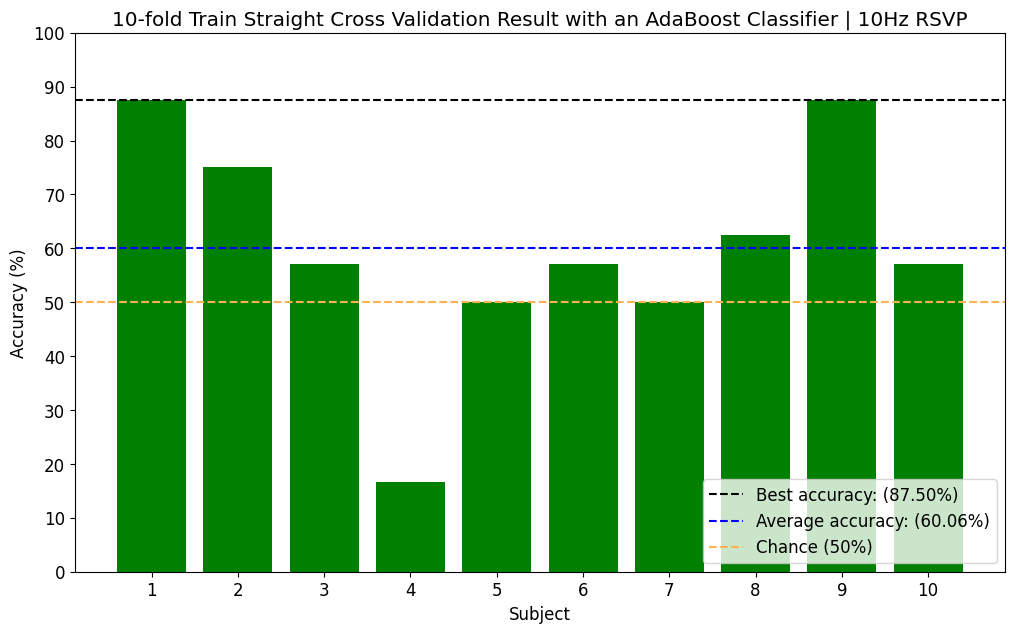

In [223]:
all_acc = np.zeros(len(all_subj_epochs))

for subj in range(len(all_subj_epochs)):

    acc = accuracy_score(all_test[subj][:,n_feat],perSubj_predicted_labels[subj]) * 100
    all_acc[subj] = acc 

#print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

fig, ax = plt.subplots(figsize=(12, 7))

idx = np.argmax(mean_acc)  # Index of the highest accuracy

plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_subj_epochs) + 1), all_acc, color="green", capsize=5)
ax.axhline(y=max(all_acc), color='k', linestyle='--', label=f'Best accuracy: ({max(all_acc):.2f}%)')
ax.axhline(y=np.mean(all_acc), color='blue', linestyle='--', label=f'Average accuracy: ({np.mean(all_acc):.2f}%)')
ax.axhline(y=50, color='#ffb152', linestyle='--', label='Chance (50%)')
ax.set(
    xticks=np.arange(1, len(all_subj_epochs) + 1),
    xlabel='Subject',
    yticks=np.arange(0, 101, step=10),
    ylabel='Accuracy (%)',
    title=f'{kfold}-fold Train Straight Cross Validation Result with an AdaBoost Classifier | {exp1} RSVP'
)
ax.legend(loc='lower right')

## **Deep Learning - Estimating the target object along the x axis in the images**

In [224]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### **Stacking and preparing data to train the NN**

In [225]:
train_vec = []
test_vec  = []

for i in range(len(all_subj_epochs)):

    train_feat = np.vstack((all_train_LVF[i], all_train_RVF[i]))
    train_lbl = np.hstack((all_subj_LVF_x_pos[i][0:len(all_train_LVF[i])], all_subj_RVF_x_pos[i][0:len(all_train_RVF[i])]))
    train_vec.append(np.hstack((train_feat[:,:-1], np.expand_dims(train_lbl,axis = 1)))) # Substitutes the original binary labels for the x positions

    test_feat = np.vstack((all_test_LVF[i], all_test_RVF[i]))
    test_lbl = np.hstack((all_subj_LVF_x_pos[i][-len(all_test_LVF[i]):], all_subj_RVF_x_pos[i][-len(all_test_RVF[i]):]))
    test_vec.append(np.hstack((test_feat[:,:-1], np.expand_dims(test_lbl,axis = 1)))) # Last column are the labels (x_pos)

# UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.

### **NN model**

In [226]:
torch.manual_seed(42)

NUM_FEATURES = len(train_vec[0][0,0:-1]) # Last row contains the x positions ()

class N2pcModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Sigmoid(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(), 
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

## **Training model**

In [227]:
all_x_preds = []
all_real_x = []

all_training_losses = []
all_testing_losses = []

# Fit the model
torch.manual_seed(42)

# Set number of epochs
dl_epochs = 20000

for i in range(len(all_subj_epochs)): 
    
# Initializing model

    x_pos_model = N2pcModel(input_features=NUM_FEATURES, 
                    output_features=1, 
                    hidden_units=8).to(device)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(x_pos_model.parameters(), 
                            lr=0.02) 
    
    print("\n")
    print("Participant: ", i+1)

    # Shuffle

    aux_train = train_vec[i]
    aux_test = test_vec[i] 

    np.random.seed(42)
    np.random.shuffle(aux_train)
    np.random.seed(42)
    np.random.shuffle(aux_test)

    # Tensor convertion
    tn_train_feat = torch.tensor(np.array(aux_train[:,0:-1])).type(torch.float32)
    tn_train_lbl = torch.tensor(np.array(aux_train[:,-1])).type(torch.float32)

    tn_test_feat = torch.tensor(np.array(aux_test[:,0:-1])).type(torch.float32)
    tn_test_lbl = torch.tensor(np.array(aux_test[:,-1])).type(torch.float32)

    # Feature wise normalization of feature vector
    n_entries, n_feat = tn_train_feat.size()

    for j in range(n_entries):

        mean = tn_train_feat[j,:].mean(dim=0)
        std = tn_train_feat[j,:].std(dim=0)
        tn_train_feat[j,:] = (tn_train_feat[j,:] - mean) / std

    n_entries, n_feat = tn_test_feat.size()

    for u in range(n_entries):

        mean = tn_test_feat[u,:].mean(dim=0)
        std = tn_test_feat[u,:].std(dim=0)
        tn_test_feat[u,:] = (tn_test_feat[u,:] - mean) / std

    training_losses = []
    testing_losses = []

    for dl_epoch in range(dl_epochs):
        ### Training
        x_pos_model.train()

        # 1. Forward pass
        x_pos_ = x_pos_model(tn_train_feat)

        # 2. Calculate loss
        train_loss = loss_fn(torch.squeeze(x_pos_), tn_train_lbl) 
        training_losses.append(train_loss.detach().numpy())
      
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        train_loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        x_pos_model.eval()
        with torch.inference_mode():
          # 1. Forward pass
          output = x_pos_model(tn_test_feat)
          # 2. Calculate test loss and accuracy
          test_loss = loss_fn(torch.squeeze(output), tn_test_lbl)
          testing_losses.append(test_loss.detach().numpy())

        # Print out what's happening
        if dl_epoch % 2000 == 0:
            print(f"Epoch: {dl_epoch} | Training Loss: {train_loss:.5f}, | Testing Loss: {test_loss:.5f}")  

    all_training_losses.append(np.array(training_losses))
    all_testing_losses.append(np.array(testing_losses))

    # ------------------------------------ Test ------------------------------------

    # 1. Set the model in evaluation mode

    x_pos_model.eval()

    # 2. Setup the inference mode context manager
    with torch.inference_mode():
      x_preds = x_pos_model(tn_test_feat)
      
    all_x_preds.append(x_preds.numpy())
    all_real_x.append(tn_test_lbl.numpy())



Participant:  1


Epoch: 0 | Training Loss: 104150.73438, | Testing Loss: 115015.21875
Epoch: 2000 | Training Loss: 13830.99707, | Testing Loss: 32331.91602
Epoch: 4000 | Training Loss: 1101.68188, | Testing Loss: 17214.82031
Epoch: 6000 | Training Loss: 498.94089, | Testing Loss: 20997.65820
Epoch: 8000 | Training Loss: 84.13516, | Testing Loss: 16981.16992
Epoch: 10000 | Training Loss: 4.91572, | Testing Loss: 20967.84961
Epoch: 12000 | Training Loss: 4.88159, | Testing Loss: 21284.58594
Epoch: 14000 | Training Loss: 0.85715, | Testing Loss: 21527.25977
Epoch: 16000 | Training Loss: 0.85724, | Testing Loss: 22148.25977
Epoch: 18000 | Training Loss: 0.85721, | Testing Loss: 22026.70312


Participant:  2
Epoch: 0 | Training Loss: 114673.32812, | Testing Loss: 107003.93750
Epoch: 2000 | Training Loss: 16089.38086, | Testing Loss: 21738.06250
Epoch: 4000 | Training Loss: 969.85217, | Testing Loss: 979.72754
Epoch: 6000 | Training Loss: 437.12384, | Testing Loss: 489.15961
Epoch: 8000 | Training Loss: 429.

In [228]:
np.shape(all_x_preds[0])

(8, 1)

### **(Engineer estimation) Size of the object within the image**

In [229]:
obj_region = (640 * 2.4)/12.6
print(obj_region)

121.90476190476191



Image size  = 12.6 cm -> 640   px ||
Object size = 2.4 cm  -> 121.9 px

### **Ploting predictions against the real values of the object's position alongisde the x-axis**

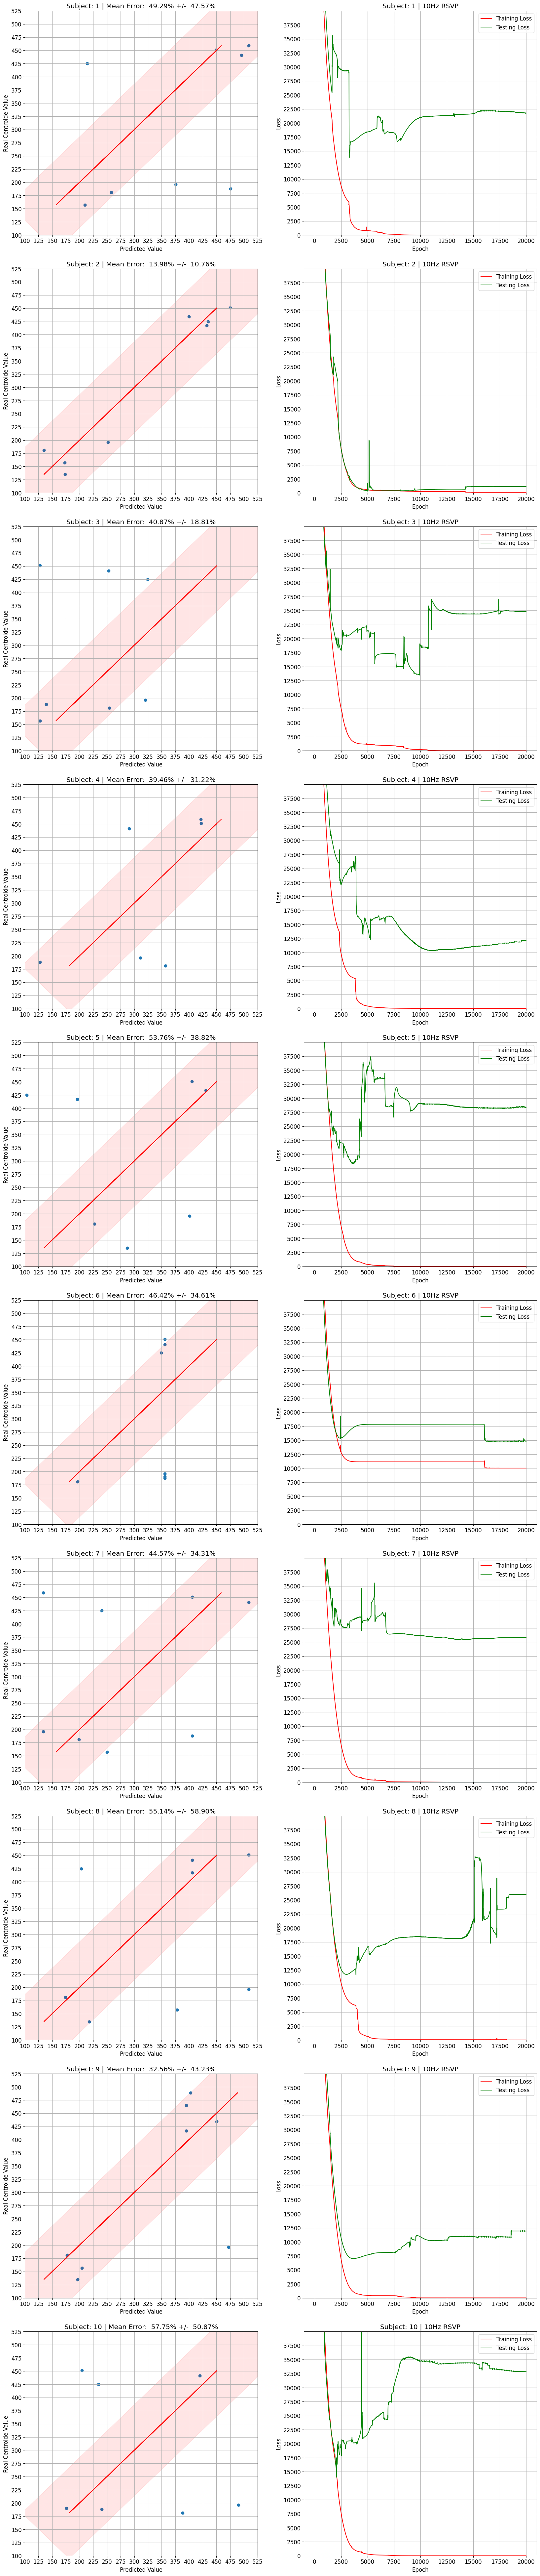

In [231]:
import math

fig, axs = plt.subplots(nrows=len(all_subj_epochs), ncols=2, figsize=(20, 100))

sc_idx = 0
pl_idx = 0

x_losses = np.linspace(0, dl_epochs, dl_epochs)

for pl in range(len(all_subj_epochs)*2):

    plt.rcParams.update({'font.size': 12})
    
    if (pl % 2 == 0) or (pl == 0):

        ax = axs[sc_idx,0]

        rel_error = (np.abs(all_x_preds[sc_idx].squeeze() - all_real_x[sc_idx])/all_real_x[sc_idx])*100

        ax.scatter(all_x_preds[sc_idx].squeeze(), all_real_x[sc_idx]);
        ax.set(xlabel='Predicted Value', 
            xticks=np.arange(100, 550, step = 25),
            xlim=(100,525),
            ylabel='Real Centroide Value',
            yticks=np.arange(100, 550, step = 25),
            ylim=(100,525),
            title=(f"Subject: {sc_idx+1} | Mean Error: {np.mean(rel_error): .2f}% +/- {np.std(rel_error): .2f}%"));
        ax.grid(True)

        ax.plot(all_real_x[sc_idx], all_real_x[sc_idx], 'r') # Line plot

        diag_rect = patches.Rectangle(
            (min(all_real_x[sc_idx]) - 50, (min(all_real_x[sc_idx]))-(obj_region/2)/math.cos(math.radians(45)) - 50), 
                                       max(all_real_x[sc_idx]) + 250, obj_region, 
                                       linewidth=1, edgecolor='r', facecolor='r', alpha=0.1, angle=45)
        ax.add_patch(diag_rect) # Patch plot

        sc_idx = sc_idx + 1

    else:

        ax = axs[pl_idx,1]

        ax.plot(x_losses, all_training_losses[pl_idx], 'r', label = 'Training Loss')
        ax.plot(x_losses, all_testing_losses[pl_idx], 'g', label = 'Testing Loss')
        ax.set(xlabel='Epoch',
               ylabel='Loss',
               yticks=np.arange(0, 40000, step = 2500),
               ylim=(0,40000),
               title=(f"Subject: {pl_idx+1} | {exp1} RSVP"));
        ax.legend(loc='upper right')
        ax.grid(True)
    
        pl_idx = pl_idx + 1
    
plt.subplots_adjust(hspace=0.15)